In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')

## Определение функций

Функции написаны в соответствии с классическим алгоритмом, описанным, например в Golyandina N., Nekrutkin V., Zhigljavsky A. *Analysis of Time Series Structure, 2001*. 

Позже планируется оформление в классы.

In [4]:
def SSA(series, l):
    '''
    series: numpy 1d array object
    l: int - a lenght of window
    
    return: np.array 3-d tensor shape (rank, l, n-l+1)
    '''
    K = series.shape[0] - l + 1
    X = np.column_stack([series[i:l+i] for i in range(K)])

    
    U, sigma, VT = np.linalg.svd(X, full_matrices = False, hermitian = False)
    
    X_output = []
    for i in range(len(sigma)):
        if sigma[i] > 0:
            X_i = sigma[i] * U[:,i].reshape(U.shape[0], 1) @ VT[i,:].reshape(1, VT.shape[1])
            X_output.append(X_i)
    return np.array(X_output)

def Henkelization(X):
    '''
    X: numpy 2d array
    
    return: numpy 1d array
    '''
    X_rev = X[::-1]
    return np.array([X_rev.diagonal(i).mean() for i in range(-X.shape[0]+1, X.shape[1])])

## Эксперименты с данными 

Используем данные о помесячном производстве пива в США 1956-1995. Данные взяты с [kaggle.com](https://www.kaggle.com/datasets/jessemostipak/beer-production/data)

In [5]:
# данные из https://www.kaggle.com/datasets/jessemostipak/beer-production/data
ts = pd.read_csv('beer_production.csv')['Monthly beer production'].to_numpy()
ts.shape

(476,)

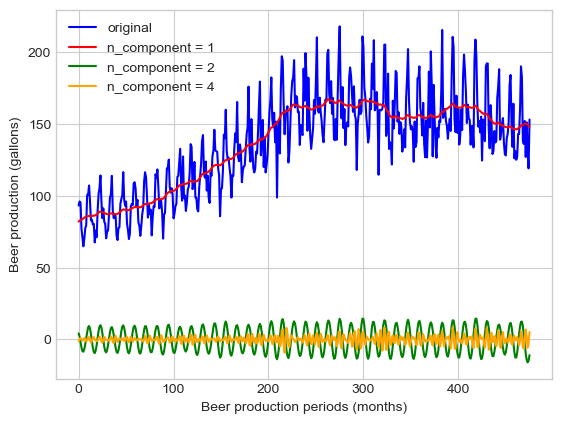

In [44]:
X_outputs = SSA(ts, l = 10)
ts_1 = Henkelization(X_outputs[0, :, :])
ts_2 = Henkelization(X_outputs[1, :, :])
ts_3 = Henkelization(X_outputs[3, :, :])

fig, ax = plt.subplots()
x = np.arange(0,ts.shape[0])
ax.plot(ts, c = 'b', label = 'original')
ax.plot(ts_1, c = 'r', label = 'n_component = 1')
ax.plot(ts_2, c = 'g', label = 'n_component = 2')
ax.plot(ts_3, c = 'orange', label = 'n_component = 4')

ax.set_xlabel('Beer production periods (months)')
ax.set_ylabel('Beer production (gallons)')
plt.legend()
plt.savefig('Fig 2. Components in SSA.png', dpi = 300);

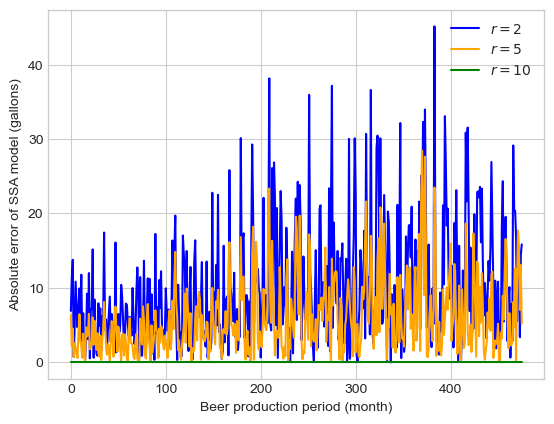

In [45]:
X_outputs = np.array(SSA(ts, l = 10))
ts_1 = Henkelization(X_outputs[:2, :, :].sum(axis = 0))
ts_2 = Henkelization(X_outputs[:5, :, :].sum(axis = 0))
ts_3 = Henkelization(X_outputs[:10, :, :].sum(axis = 0))

x = np.arange(0,ts.shape[0])
error_1 = np.abs(ts - ts_1)
error_2 = np.abs(ts - ts_2)
error_3 = np.abs(ts - ts_3)

fig, ax = plt.subplots()
ax.plot(error_1, c = 'b', label  = '$r=2$')
ax.plot(error_2, c = 'orange', label = '$r=5$')
ax.plot(error_3, c = 'g', label = '$r=10$')

ax.set_xlabel('Beer production period (month)')
ax.set_ylabel('Absolute error of SSA model (gallons)')
plt.legend()
plt.savefig('Fig 3. Dependence of error with increasing rank.png', dpi = 300);

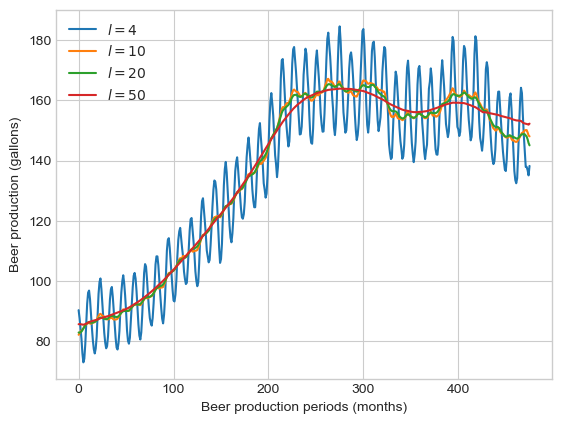

In [9]:
# посмотрим на изменение первой компоненты при разных параметрах окна

window_lengths = [4,10,20,50]
fig, ax = plt.subplots()
for l in window_lengths:
    X = SSA(ts, l = l)[0]
    ts_new = Henkelization(X)
    
    ax.plot(ts_new, label = f'$l = {l}$')

ax.set_ylabel('Beer production (gallons)')
ax.set_xlabel('Beer production periods (months)')
plt.legend()
plt.savefig('Fig 4. Dependecy from widow length.png', dpi = 300)

In [14]:
# посмотрим на время работы алгоритма
from time import time
from tqdm import tqdm

time_complexity = []
for n in tqdm(range(4,10**5, 100)):
    ts = np.random.normal(size = (n,))
    start = time()
    X = SSA(ts, l = 4)
    X_ts = np.zeros((4, n-4+1))
    for i in range(10):
        try:
            X_ts += X[i]
        except IndexError:
            break
    ts_new = Henkelization(X_ts)
    end = time()
    
    time_complexity.append(end-start)

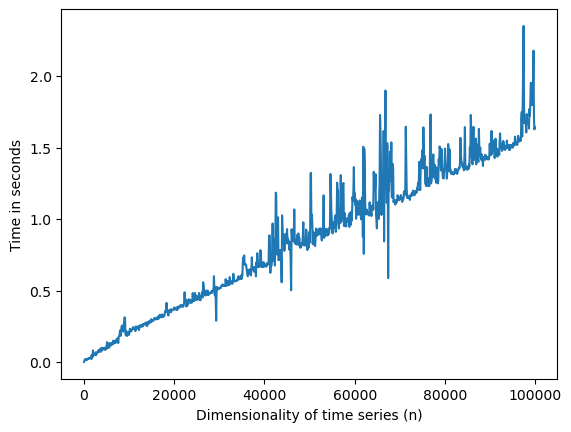

In [23]:
# действительно, ассимптотика в случае l < n-l+1 похожа на линейную с 
fig, ax = plt.subplots()
ax.plot(range(4,10**5,100), time_complexity);
ax.set_ylabel('Time in seconds')
ax.set_xlabel('Dimensionality of time series (n)');
plt.savefig('Fig 1. Computation time of SSA.png')

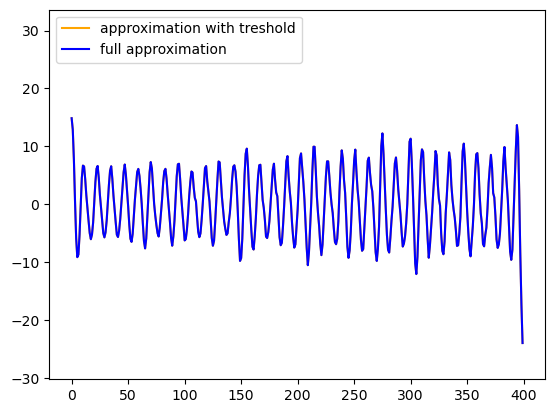

In [5]:
# попробуем посмотреть, что меняется, если взять больше наблюдений 
# если treshold взять близким к 400, то временные ряды будут очень сильно совпадать
from matplotlib.animation import ArtistAnimation

fig, ax = plt.subplots()
frames = []

for treshold in range(30,401):
    ts_1 = ts[:treshold]
    ts_2 = ts[:400]

    X_1 = SSA(ts_1, l = 10)[2]
    X_2 = SSA(ts_2, l = 10)[2]

    SSA_ts_1 = Henkelization(X_1)
    SSA_ts_2 = Henkelization(X_2)[:treshold] # full time series component

    line = ax.plot(range(treshold), SSA_ts_1, 'orange', range(treshold), SSA_ts_2, 'blue')
    frames.append(line)

ax.legend(['approximation with treshold', 'full approximation'])
animation = ArtistAnimation(fig, frames, interval = 10, blit = True, repeat = True) 
animation.save('Gif2.gif', fps = 60)
plt.show()

## Иллюстративный пример

Путь наш временной ряд описывается простой зависимостью $y = 2x, x \in {0,1...4}$. Тогда $y = (0,2,4,6,8)$. 

Траекторная матрица для длинны окна $l=2$
$$
Y = \begin{pmatrix}
0 & 2 & 4 & 6 \\
2 & 4 & 6 & 8
\end{pmatrix}
$$

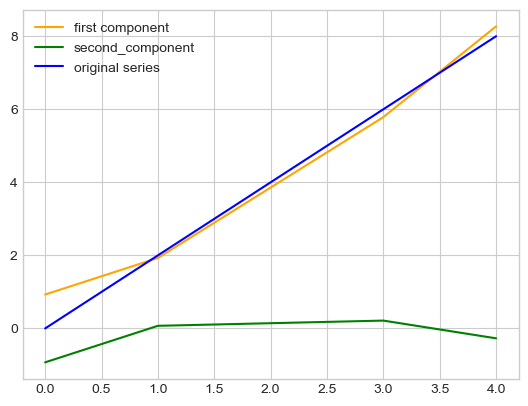

In [3]:
Y = np.array([[0,2,4,6], [2,4,6,8]])
x = np.arange(5)

U, sigma, V = np.linalg.svd(Y, full_matrices = False)

first_component = (U[:, 0][:, np.newaxis] * sigma[0] * V[0, :])[::-1]
first_component = np.array([first_component.diagonal(i).mean() for i in range(-first_component.shape[0]+1, first_component.shape[1])])

second_component = (U[:, 1][:, np.newaxis] * sigma[1] * V[1, :])[::-1]
second_component = np.array([second_component.diagonal(i).mean() for i in range(-second_component.shape[0]+1, second_component.shape[1])])

plt.plot(x, first_component, c = 'orange', label = 'first component')
plt.plot(x, second_component, c = 'green', label = 'second_component')
plt.plot(x, 2*x, c = 'b', label = 'original series')
plt.legend()
plt.savefig('Illustrative example of SSA for linear series.png', dpi = 300)
plt.show()

## Визуализация тренда, сезонности и шума


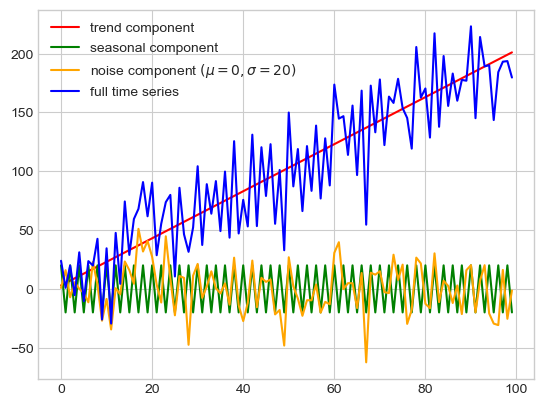

In [13]:
x = np.arange(100)
trend = 2*x + 3
harmonic = 20*np.cos(x*np.pi)
noise = np.random.normal(0,20, size = 100)

plt.plot(x, trend, color = 'red', label = 'trend component')
plt.plot(x, harmonic, color = 'green', label = 'seasonal component')
plt.plot(x, noise, color = 'orange', label = 'noise component $(\mu = 0, \sigma = 20)$')
plt.plot(x, trend + harmonic + noise, c = 'b', label = 'full time series')

plt.legend()
plt.savefig('Series decomposition example.png', dpi = 300)
plt.show()

array([-1.32649788e+00,  1.41820333e+00,  1.24426791e+00, -4.36322462e-01,
        8.21692979e-01,  1.70806686e+00,  7.27063450e-01, -5.17136317e-03,
        2.44762005e-01,  1.40038440e+00, -5.44058055e-01,  1.58864112e+00,
        1.13492489e+00, -2.52465757e-01,  9.45173539e-01,  6.46061141e-01,
       -6.94604192e-01,  1.42823733e-02, -1.07834082e+00,  1.11733205e+00,
        1.87275483e-01,  3.63101319e-01, -6.66442490e-02, -6.08314918e-01,
        7.72321772e-02, -1.61233401e-01, -6.75515790e-01, -5.28742332e-02,
        2.12766418e-01, -6.00829982e-01, -5.52201792e-01, -1.36083079e+00,
       -1.48167442e-01, -1.76018988e-01, -7.53272157e-01,  2.25287298e-01,
        2.05598568e-02, -1.00068600e+00,  5.13650133e-01,  2.93330748e-01,
       -1.48262979e+00, -4.16271904e-02, -1.05973137e+00,  2.12454413e-01,
       -2.29088306e-01,  9.02835571e-01,  9.34891097e-01,  3.18247713e-01,
       -8.74107391e-01, -2.31630748e+00,  3.59778364e-01,  1.99540331e+00,
       -3.42585178e-01, -